# CS345 Project

## Team Members
1. Hamad Alyami
2. Benito Encarnacion

## Dataset
Our dataset was from Kaggle by a user called Mexwell. The data is paragraphs scraped from wikipedia in 2018 in 235 languages.

The dataset contains 235,000 datasets with balance between language proportions and a test and train split provided.

The downloaded folder from Kaggle contains:
- labels.csv: A file containing the language name, 2-3 letter code, German name, and language family of all the languages present in the dataset.
- README.txt: A file explaining the folder contents.
- urls.txt: A file containing the urls of where the paragraphs were found.
- x_test.txt: The testing data samples, paragraphs in multiple languages.
- x_train.txt: The training data samples, paragraphs in multiple langauges
- y_test.txt: The labels for the testing dataset, using the 2-3 letter codes found in labels.csv.
- y_train.txt: The labels for the training dataset, using the 2-3 letter codes found in labels.csv


## Project
Our project is to train and compare two ML models on the Latin Alphabet languages present in the dataset and compare their performance.

## Motivation
We decided to do this project because it allows us to explore practical applications of natural language processing and machine learning by working with real-world multilingual data. Language identification is an important task in many systems and applications like search engines, translation tools, and content moderation. Working with such a dataset gives us the opportunity to apply classification techniques in a meaningful way. By focusing on languages that use the Latin alphabet, we avoid complications from different writing systems while still working with a variety of languages.

## Models
The models we decided to work with in this project are:
- Multinomial Naive-Bayes (MNB): Uses word frequencies in each class, langauges in our case, to guess the most likely class for text it has not seen.

- Feed Forward Neural Network (FNN): An artificial Neural Network where information moves from input to output without looping back. It uses neurons, connected nodes, to learn patterns and make predictions.

### Data Preprocessing
We will begin by reading the data from the files then:
1. Remove Null Values
2. Filter to keep texts of languages we want using the 2-3 letter codes
3. Return both samples from x_test and x_train and labels from y_test and y_train stacked into X and y

In [31]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import train_test_split

# from sklearn.metrics import accuracy_score

#Understanding the data set
import pandas as pd
import numpy as np
            #Italina, French, Spanish, Portugese, English, German, Dutch, Indonesian, Finnish, Hausa
lang_codes = ['ita', 'fra', 'spa', 'eng', 'ind']
langs = ['Italian', 'French', 'Spanish', 'English', 'Indonesian']

def file_to_np_array(path, label):
    try:
        df = pd.read_csv(path, sep='<NonExistenceSeparator>', header=None, engine='python')
        print(f"{label}: Read!")
    except Exception as e:
        print(f"Error reading the {label} file: {e}")
        return None
    return df.to_numpy()


def clean_np_data(X, y):
    stacked = np.hstack((y, X)) # Stack y and X side by side
    # print(stacked.shape)
    clean_stacked = stacked[~np.any(pd.isna(stacked), axis=1), :] # Remove empty values
    # print(clean_stacked.shape)
    true_clean = clean_stacked[np.isin(clean_stacked[:,0], lang_codes),:] # Remove all rows that aren't our target languages
    # print(true_clean.shape)
    return true_clean[:,1], true_clean[:,0] # Return cleaned as X and y split again

def clean_filter_and_stack(X_train_file, y_train_file, X_test_file, y_test_file):
    X_train_clean, y_train_clean = clean_np_data(file_to_np_array(X_train_file, X_train_file), 
                                       file_to_np_array(y_train_file, y_train_file))
    X_test_clean, y_test_clean = clean_np_data(file_to_np_array(X_test_file, X_test_file), 
                                       file_to_np_array(y_test_file, y_test_file))
    return np.hstack((X_train_clean, X_test_clean)).astype(str), np.hstack((y_train_clean, y_test_clean)).astype(str)

X, y = clean_filter_and_stack("Data/x_train.txt", 
                                      "Data/y_train.txt", 
                                      "Data/x_test.txt", 
                                      "Data/y_test.txt")

print(X.shape, y.shape)

Data/x_train.txt: Read!
Data/y_train.txt: Read!
Data/x_test.txt: Read!
Data/y_test.txt: Read!
(5000,) (5000,)


#### Data Discovery
This code is to find what is the sample distribution between languages and average word count of each sample of each language.

In [32]:
def avg_words(filtered_X):
    total = 0
    for text in filtered_X:
        words = str(text).split()
        total += len(words)

    return total / len(filtered_X)

def word_count_perlang(X, y):
    avg_word_count = []
    for lang in lang_codes:
        filtered_X = X[y == lang]
        avg_word_count.append(avg_words(filtered_X))
    
    return avg_word_count

def lang_perc(y):
    lang_perc = []
    total = len(y)
    for lang in lang_codes:
        count = (y == lang).sum()
        percent = (count / total) * 100
        lang_perc.append(percent)
    return lang_perc

df = pd.DataFrame({
    'Language': langs,
    'Percent of Dataset (%)': lang_perc(y),
    'Average Word Count': word_count_perlang(X, y)
})

display(df)

# from sklearn.naive_bayes import MultinomialNB

# model = MultinomialNB()
# model.fit(X_train_vectors, y_train)
# print("Done training MNB")

# y_pred = model.predict(X_test_vectors)
# accuracy = accuracy_score(y_test, y_pred)
# print("Overall accuracy of MNB: " + str(accuracy * 100) + "%")



,Language,Percent of Dataset (%),Average Word Count
0,Italian,20.0,68.192
1,French,20.0,67.707
2,Spanish,20.0,67.295
3,English,20.0,70.455
4,Indonesian,20.0,57.147


#### Data Split
Here we use Sklearn train_test_split to split our data into 70/30 train and test splits, respectively, after shuffling them randomly.

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3500,) (3500,)
(1500,) (1500,)


And then vectorize our dataset for the MNB.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(strip_accents='unicode')
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)
print("Done vectorizing")

Done vectorizing


We train our MNB using the MultinomialNB() function from sklearn on X_train which is 70% of our dataset.

### MNB
The sklearn MNB implementation has two main hyperparameters, alpha and fit_prior.

- alpha is used to smooth the data, so the model doesn’t get confused if a word doesn’t appear in some languages. This helps prevent errors, especially when some words are rare. The default value alpha=1.0 usually works well for text data like ours.

- fit_prior decides whether the model should learn how common each language is from the training data. Since all our language samples are balanced (equal amounts), the default setting (True) works fine.

So, for our language detection project, we don’t need to change these settings — the defaults are already a good fit.

In [35]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_vectors, y_train)
print("Done training MNB")

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_vectors)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy of MNB: " + str(accuracy * 100) + "%")

Done training MNB
Overall accuracy of MNB: 98.93333333333332%


Considering our MNB accuracy is unexpectadly hard, we decided to add 5 more languages; Hausa, Portugese, Finnish, German, and Dutch. This is to introduce more languages that are similar like German and Dutch and Spanish and Portugese but at the same time some that are different like Hausa from all the others.

In [36]:
lang_codes = ['ita', 'fra', 'spa', 'por', 'eng', 'deu', 'nld', 'ind', 'fin', 'hau']
langs = ['Italian', 'French', 'Spanish', 'Portuguese', 'English', 'German', 'Dutch', 'Indonesian', 'Finnish', 'Hausa']

In [37]:
X, y = clean_filter_and_stack("Data/x_train.txt", 
                                      "Data/y_train.txt", 
                                      "Data/x_test.txt", 
                                      "Data/y_test.txt")

df = pd.DataFrame({
    'Language': langs,
    'Percent of Dataset (%)': lang_perc(y),
    'Average Word Count': word_count_perlang(X, y)
})

display(df)

Data/x_train.txt: Read!
Data/y_train.txt: Read!
Data/x_test.txt: Read!
Data/y_test.txt: Read!


,Language,Percent of Dataset (%),Average Word Count
0,Italian,10.0,68.192
1,French,10.0,67.707
2,Spanish,10.0,67.295
3,Portuguese,10.0,66.184
4,English,10.0,70.455
5,German,10.0,59.762
6,Dutch,10.0,55.657
7,Indonesian,10.0,57.147
8,Finnish,10.0,48.431
9,Hausa,10.0,75.802


We can still see that the data is still equally distributed, with each language being 10% of the data set. We do see a discrepency however in the average word count of the samples for each langugae, with overall average being around 65. We see that Finnish has an average of 48 words, the lowest, and Haussa has the highest.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

vectorizer = CountVectorizer(strip_accents='unicode')
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)
print("Done vectorizing")

model = MultinomialNB()
model.fit(X_train_vectors, y_train)
print("Done training MNB")

y_pred = model.predict(X_test_vectors)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy of MNB: " + str(accuracy * 100) + "%")

(7000,) (7000,)
(3000,) (3000,)
Done vectorizing
Done training MNB
Overall accuracy of MNB: 98.1%


The overall accuracy is still really good, much more than what we anticipated or expected.

In [39]:
def get_lang_accuracies(y_true, y_pred):
    df = pd.DataFrame({'language': y_true, 'pred': y_pred})
    accuracies = []

    for lang in lang_codes:
        lang_group = df[df['language'] == lang]
        if len(lang_group) > 0:
            acc = accuracy_score(lang_group['language'], lang_group['pred'])
        else:
            acc = 0
        accuracies.append(acc)
    
    percent_accuracies = [x * 100 for x in accuracies]
    df = None
    return percent_accuracies

df_MNB_lang = pd.DataFrame({
    'Language': langs,
    'Accuracy of MNB/language': get_lang_accuracies(y_test, y_pred)
})

display(df_MNB_lang)

,Language,Accuracy of MNB/language
0,Italian,96.855346
1,French,99.335548
2,Spanish,97.647059
3,Portuguese,93.728223
4,English,100.000000
5,German,97.569444
6,Dutch,98.275862
7,Indonesian,98.615917
8,Finnish,99.315068
9,Hausa,99.662162


#### Accuracy
We see that the over all accuracy is 98.1 which is still very high and didn't expect. More so, we see that English has a 100% accuracy. We would like to also note how Portugese is the lowest with 93.7% and Finnish is the second best with an almost perfect accuracy of 99.3%.

We will attempt to explore the model more and theorize why we ended up with such results down below.

In [40]:
def top_words_per_lang(model, vectorizer, top_n=5):
    feature_names = vectorizer.get_feature_names_out()
    log_probs = model.feature_log_prob_
    class_indices = {label: i for i, label in enumerate(model.classes_)}
    
    return [
        [feature_names[i] for i in log_probs[class_indices[lang]].argsort()[::-1][:top_n]]
        for lang in lang_codes
    ]

df_top_words_MNB = pd.DataFrame({
    'Language': langs,
    'Top words per lang' :top_words_per_lang(model, vectorizer, 5)
})

pd.set_option('display.max_colwidth', None) 

display(df_top_words_MNB)

,Language,Top words per lang
0,Italian,"[di, il, la, in, del]"
1,French,"[de, la, le, en, et]"
2,Spanish,"[de, la, en, el, que]"
3,Portuguese,"[de, em, do, que, da]"
4,English,"[the, of, in, and, to]"
5,German,"[der, die, und, in, von]"
6,Dutch,"[de, van, in, het, een]"
7,Indonesian,"[yang, dan, di, pada, dari]"
8,Finnish,"[ja, on, oli, han, vuonna]"
9,Hausa,"[da, ta, ya, na, ne]"


We used this function to identify what are the top 5 words that the model, MultinomialNB(), found to be the most indicative of a class. To do this, we used MultinomialNB()'s **feature_log_prob_ variable**, which stores the log-probability of each word (feature) given each class (language). This means it tells us how strongly each word is associated with each language according to the model.

The shape of this variable is **(n_classes, n_features)**, where n_classes is the number of languages and n_features is the number of unique words in the vocabulary. Each row shows the log-probabilities for one class, and each column represents a word. The higher the value, the more important that word is for predicting that class.

We collected the top 5 because it provides a good balance between being explanatory and concise.

In [41]:
def compute_overlap_matrix(top_words_list):
    n = len(lang_codes)
    matrix = []

    for i in range(n):
        row = []
        for j in range(n):
            overlap = len(set(top_words_list[i]).intersection(top_words_list[j]))
            row.append(overlap)
        matrix.append(row)

    return pd.DataFrame(matrix, index=lang_codes, columns=lang_codes)

top_words_list = top_words_per_lang(model, vectorizer, 5)
overlap_df = compute_overlap_matrix(top_words_list)

#### Top Words in all Languages
In the cell below we find the top 5 words that appear in all languages.

In [42]:
def find_shared_words(word_lists):
    word_counts = {}
    
    for word_list in word_lists:
        for word in word_list:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

    shared = []
    for word, count in word_counts.items():
        if count > 1:
            shared.append(word)

    return shared

shared_words = find_shared_words(top_words_list)
print("Words appearing in more than one language, top 5:", shared_words)

Words appearing in more than one language, top 5: ['di', 'la', 'in', 'de', 'en', 'que', 'da']


#### Heat-map of Words Correlation between Languages
Here we use a matplot to give a colored heat-map of how many words of our top 5 from each language meet between each language.

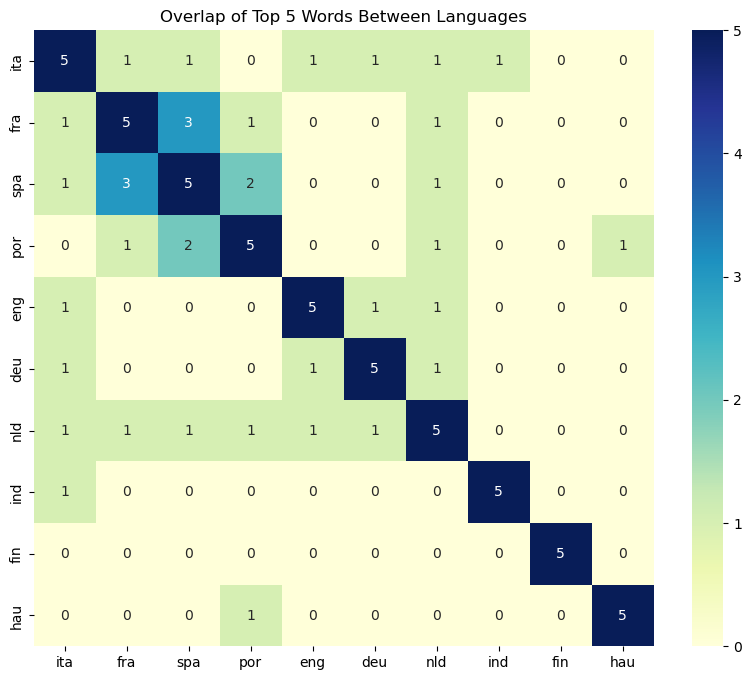

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(overlap_df, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Overlap of Top 5 Words Between Languages")
plt.show()

In the heat-map we find without any surprise that between each language and itself a 5. Next French and Spanish meet with 3 words and then Portugese and Spanish.

When focusing on English and Finnish, we see more. Finnish has absolutly no correlation in its top 5 words with any other language while English still has some, 1 word each, with some other languages. This explains why Finnish has such a high accuracy but why not higher than English?

In [44]:
analyzer = vectorizer.build_analyzer()

def count_top_words_in_lang_samples(X, y, top_words_count):
    results = []
    for i, lang in enumerate(lang_codes):
        lang_samples = X[y == lang]
        word_counts = []

        for word in top_words_list[i]:
            count = sum(word in analyzer(text) for text in lang_samples)
            word_counts.append(count)

        results.append(word_counts)
    return results

def MNB_words_table(top_words, top_words_count):
    for i, lang in enumerate(langs):
        print(lang + ":")
        df = pd.DataFrame({
            "Word": top_words[i],
            "Count in Dataset": top_words_count[i]
        })
        display(df)

top_words = top_words_per_lang(model, vectorizer, 5)
top_counts = count_top_words_in_lang_samples(X, y, top_words)

MNB_words_table(top_words, top_counts)

Italian:


,Word,Count in Dataset
0,di,787
1,il,646
2,la,657
3,in,563
4,del,501


French:


,Word,Count in Dataset
0,de,939
1,la,780
2,le,732
3,en,665
4,et,717


Spanish:


,Word,Count in Dataset
0,de,940
1,la,850
2,en,801
3,el,783
4,que,533


Portuguese:


,Word,Count in Dataset
0,de,877
1,em,632
2,do,561
3,que,495
4,da,566


English:


,Word,Count in Dataset
0,the,939
1,of,793
2,in,808
3,and,818
4,to,584


German:


,Word,Count in Dataset
0,der,790
1,die,686
2,und,713
3,in,622
4,von,480


Dutch:


,Word,Count in Dataset
0,de,922
1,van,813
2,in,793
3,het,732
4,een,730


Indonesian:


,Word,Count in Dataset
0,yang,724
1,dan,750
2,di,564
3,pada,490
4,dari,503


Finnish:


,Word,Count in Dataset
0,ja,782
1,on,484
2,oli,296
3,han,212
4,vuonna,235


Hausa:


,Word,Count in Dataset
0,da,877
1,ta,591
2,ya,518
3,na,587
4,ne,595


Here we see something that would explain things more a bit. We notice that English has a high count overall of the top 5 words in the samples we have. Perhaps not the highest, but the higher ones are found in more than one language, like 'de'. While 'the' is slightly less in count but is only found in English.

This gives a very good idea on why English has the highest accuracy, not only does it have a relatively high count of indicative words by the MNB, but also these words are special and are not found in other languages.

Furhtermore, while Finnish as we saw in the heatmap has no correlation with any other language in our dataset, its top 5 indicative words by the MNB are way less than English, which explains why it performs worse than English even though English has correlation in indicative words with other languages.

Finally, we see that while not the lowest, Portuguese is on the lower end in terms of the frequency of those special words. Combined with the fact that its words correlate with multiple other languages like Spanish and Dutch explains why it has such a low accuracy.

Dutch's top 5 words meets all other languages in the heat-map except for 3. But with a high frequency of those words in the text samples it still performs relatively well.

### K-Fold
Since our accuracy is high, we will perform k-folds on the dataset using MNB to see how well our model generalizes on unseen data. We choose the optimal number of folds of 5 since it has a balance of testing the model but not being too heavy.

In [45]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

model_kfold = make_pipeline(CountVectorizer(), MultinomialNB())
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=17)

all_preds = []
all_true = []

X_train_kfold = X_train.copy()
X_test_kfold = X_test.copy()
y_train_kfold = y_train.copy()
y_test_kfold = y_test.copy()

k_folds_accuracies = []
for i, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train_kfold, X_test_kfold = X[train_index], X[test_index]
    y_train_kfold, y_test_kfold = y[train_index], y[test_index]

    model_kfold.fit(X_train_kfold.flatten(), y_train_kfold.flatten())
    y_pred_kfold = model_kfold.predict(X_test_kfold.flatten())

    fold_accuracy = accuracy_score(y_test_kfold, y_pred_kfold)
    k_folds_accuracies.append(fold_accuracy)

    all_preds.extend(y_pred_kfold)
    all_true.extend(y_test_kfold)

In [46]:
df_kfold_accuracy = pd.DataFrame({
    'Kfold': [1, 2, 3, 4, 5],
    'Accuracy': k_folds_accuracies
})


print("Cross-Validation Results (Accuracy):")

display(df_kfold_accuracy)

print(f'\nOverall Kfolds Mean Accuracy: {cross_val_score(model_kfold, X.flatten(), y.flatten(), cv=kf).mean() * 100:}%')

def get_lang_accuracies(y_true, y_pred):
    df = pd.DataFrame({'language': y_true, 'pred': y_pred})
    accuracies = []

    for lang in lang_codes:
        lang_group = df[df['language'] == lang]
        if len(lang_group) > 0:
            acc = accuracy_score(lang_group['language'], lang_group['pred'])
        else:
            acc = 0
        accuracies.append(acc)

    return accuracies

df_lang_accuracy = pd.DataFrame({
    'Language': langs,
    'Accuracy of MNB/language': get_lang_accuracies(np.array(all_true), np.array(all_preds))
})

display(df_lang_accuracy)

Cross-Validation Results (Accuracy):


,Kfold,Accuracy
0,1,0.9825
1,2,0.9830
2,3,0.9825
3,4,0.9860
4,5,0.9840



Overall Kfolds Mean Accuracy: 98.36%


,Language,Accuracy of MNB/language
0,Italian,0.985
1,French,0.993
2,Spanish,0.980
3,Portuguese,0.949
4,English,0.998
5,German,0.982
6,Dutch,0.980
7,Indonesian,0.978
8,Finnish,0.996
9,Hausa,0.995


We see from the results from the K-folds that the accuracy is still consistent which indicates to use that the model is quite robust. The accuracies are also consistent for the languages.

Due to these results we will assume that the top 5 words indicative for MNB will be similar to what we found previously.

#### 

### MNB Conclusions
While we haven't anticipated this high of an accuracy for our MNB, intuitively it makes sense. There are certain words that are only found in certain languages and they appear quite often in most sentences, like articles in English. And while some other languages have correlation when it comes to the indicative words their count and combination with other unique words in the language makes it possible for the MNB to classify the language accuratly.

Thus, MNB performs quite well when given decently sized texts from languages to train on, like paragraphs. This gives it the ability to record the most common words in that language and the unique words that exist in the language.

When testing, if given a valid sentence, it will be able to accuratly classify it sense for example, a simple sentence in English no matter how short will contain articles, verbs, or adjectives.



In [47]:
X_test_addtl = np.array([
    # Italian
    "Bambini ridevano mentre guardavano fuochi sopra ponte vecchio.",
    "Neve fresca copriva tetto rustico durante alba tranquilla.",

    # French
    "Clé cassée resta coincée sous meuble ancien.",
    "Lumière faible éclairait couloir désert chaque nuit.",

    # Spanish
    "Guitarra sonaba cerca ventana rota durante fiesta secreta.",
    "Sombras largas cruzaban pasillo viejo sin sonido alguno.",

    # Portuguese
    "Barco afundou devagar próximo cais silencioso.",
    "Fumaça subia após explosão repentina dentro fábrica antiga.",

    # English
    "Impetus convive.",
    # "afjlkasdf",
    "Galvanized Acumen.",

    # German
    "Regen fiel schnell gegen Bäume kahlen draußen.",
    "Kerze flackerte still auf Tisch zerkratzt alt.",

    # Dutch
    "Stilte hing rond toren verlaten zonder mensen.",
    "Kleine boot dreef langzaam over meer breed.",

    # Indonesian
    "Topi merah jatuh ke lantai tanpa suara.",
    "Malam gelap membawa angin kencang lewat bukit.",

    # Finnish
    "Hiljainen järvi heijasti kuun valoa yössä.",
    "Vanha mies kulki polkua pitkin varhain aamulla.",

    # Hausa
    "Gashi nata ya bushe daga iska mai sanyi.",
    "Kwalliya ta fadi kan kasa lokacin dare ya zo."
])

y_test_addtl = np.array(['ita', 'ita', 'fra', 'fra', 'spa', 'spa', 'por', 'por',
                        'eng', 'eng', 'deu', 'deu', 'nld', 'nld', 'ind', 'ind',
                        'fin', 'fin', 'hau', 'hau'])

In [48]:
vectorizer = CountVectorizer(strip_accents='unicode')
X_train_vectors = vectorizer.fit_transform(X_train)  # Fit only on training
X_test_addtl_vect = vectorizer.transform(X_test_addtl)

y_pred_addtl = model.predict(X_test_addtl_vect)
accuracy_addtl = accuracy_score(y_test_addtl, y_pred_addtl)
print("Overall accuracy of MNB: " + str(accuracy_addtl * 100) + "%")

Overall accuracy of MNB: 90.0%


# Feed Forward Neural Network

We decided to do a Neural Network to give us some exposure into this rich topic. Feed Forward specifically are simpler to train and apply than other types of neural networks.

In this model we basically have two shown layers, input and output, where the data goes in and out. In between, there can be multiple hidden layers that would help in the training. We have the freedom in choosing the amount of layers and the amount of neurons in each layer.

This gives us simplicity but more abilities than MNB. In MNB where we feed it vectorized data, statistics about the words and their frequencies in each sample, it relies only on those statistics and disregards grammar and word positioning. When we feed the FFNN model the strings of text converted to Unicode and normalized, it enables the neural network to have data with vectors where each value doesn't only represent what character, but also where it occurs in the word using its position in the vector. An example of this would be the suffix "tion", which appears as the last 4 values in an array representing a word, thus allowing the neural network to learn that pattern.

This should enable us to have a better model when it comes to generalizing on new data since it learns more patterns than just frequency and words, like positioning.

### Data Pre-processing
FFNN (Feed Forward Neural Network) needs a numerical set of labels as opposed to MNB due to the need for the FFNN to use the class labels in its internal mathematical operations, like matrix multipications and so on.

In [49]:
# Reorganizing data for Feed Forward Neural Network input

# 1) convert string labels into integer labels
#      and make func to convert back


def str_labels_to_int_labels(labelArr, string_labels):
    rtn = np.empty(labelArr.shape, dtype=int)
    for i, v in enumerate(string_labels):
        rtn[labelArr == v] = i
    return rtn

def int_labels_to_str_labels(labelArr, string_labels):
    rtn = np.empty(labelArr.shape, dtype='object')
    for i, v in enumerate(string_labels):
        rtn[labelArr == i] = v
    return rtn

# print(y_test[0:5])
# y1 = str_labels_to_int_labels(y_test, all_str_labels)
# print(y1[0:5])
# y2 = int_labels_to_str_labels(y1, all_str_labels)
# print(y2[0:5])

When it comes to pre-processing the text samples themselves we had multiple choices. We could use CountVectorizer like MNB, or turn the characters into unicode values, pad the vectors to be of equal length, then normalize them before feeding them to the model.

The reason we chose the second method over CountVectorizer is because when using CountVectorizer all the positioning part of our dataset would removed and we would left with words in each language and their frequency, thus our neural network would act like the MNB using those statistics to predict the class. When doing our method of data processing however, we retain the the positioning aspect of the dataset on top of the vocabulary and frequency.

In [50]:
# 2) convert data into multi-column matrix of characters
#      and make func to convert back

def str_vec_to_float_matrix(strVec, longest_str_len):
    # Pad strings to all be equal length
    padded_strVec = np.char.ljust(strVec, longest_str_len, fillchar=' ')

    # turn vector of strings into matrix of characters
    stacked_char_matrix = np.vstack([np.array(list(s)) for s in padded_strVec])

    # turn char matrix into int matrix
    char_matrix_to_int_matrix = np.vectorize(ord)
    int_matrix = char_matrix_to_int_matrix(stacked_char_matrix)

    #normalize and scale so each value is a float between 0 and 1
    matrix_max = np.max(int_matrix)
    matrix_min = np.min(int_matrix)
    min_subtracted_matrix = int_matrix - matrix_min
    normalized_matrix = (min_subtracted_matrix / (matrix_max - matrix_min))
    return normalized_matrix

In [51]:
# 3) use them both

def convert_to_FFNN_format(Xr, Xe, yr, ye):
    max_str_len_1 = np.max(np.char.str_len(Xr))
    max_str_len_2 = np.max(np.char.str_len(Xe))
    max_str_len = max(max_str_len_1, max_str_len_2)
    Xr_rtn = str_vec_to_float_matrix(Xr, max_str_len)
    Xe_rtn = str_vec_to_float_matrix(Xe, max_str_len)
    return (Xr_rtn, 
            Xe_rtn,
            str_labels_to_int_labels(yr, lang_codes), 
            str_labels_to_int_labels(ye, lang_codes))

(X_tr_nn, X_te_nn, y_tr_nn, y_te_nn) = convert_to_FFNN_format(X_train, X_test, y_train, y_test)

print("Done converting data into FFNN format")

Done converting data into FFNN format


Now that our labels are numerically encoded and our samples are changed into their unicode values and normalized we can feed them into the neural network.

In [52]:
# print(X_tr_nn[0])
# print(X_tr_nn[1])
print(X_tr_nn.shape)
print(X_te_nn.shape)

(7000, 5577)
(3000, 5577)


7000/3000 showing our data split for training and testing samples, with 5577 features representing the amount of character. 5577 was the max character count in our samples so the rest are padded with empty spaces to make them equal length.

### Tensorflow Feed Forward Neural Network
TensorFlow’s FFNN takes input data, passes it through hidden layers to learn patterns, and outputs class probabilities. You control its behavior with hyperparameters like number of layers, neurons, activations, and optimizers. All in one framework.

We chose Tensorflow because of the many resources online that has explains how it works and provides tutorials on how to implement and use it.

In [53]:
# Applying properly structured data to a basic FFNN

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy

print("Done importing Tensorflow Stuff")

Done importing Tensorflow Stuff


#### FFNN Layers
We use sequential to create the layers of our neural network.

It has the hyperparameters of:
- Dense(unit): unit is the number of neurons in the level.
- input_shape: the length of the input data, in our case 5577
- Activation Function: 'Relu' a popular function for internal neurons to deep learn and 'softmax' for the output function to turn raw outputs into vector of probailities

When compliling the model we use the hyperparameters:
- Optimizer: the algorithm to update the weights, we use Adam() since it good for most problems without much tuning
- Loss Function: A function to measure the error we use SparseCategoricalAccuracy to measure how far they are from the correct classes
- Metrics: We use SparseCategoricalAccuracy since it enables us to calculate how often the model classifies data correctly

In [54]:
# Make FFNN

sample_length = X_tr_nn[0].shape[0]

FFNN_model = Sequential([
    Input((sample_length,)),
    Dense(1024, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

FFNN_model.compile(optimizer=Adam(),
                   loss=SparseCategoricalCrossentropy(), 
                   metrics=[SparseCategoricalAccuracy()])

Here we run the model for as many as FFNN_epochs times

In [ ]:
FFNN_epochs = 10
for i in range(FFNN_epochs):
    FFNN_model.fit(X_tr_nn, y_tr_nn)
    if (i%5 == 0):
        # print("\n", i, ": ")
        test_loss, test_acc = FFNN_model.evaluate(X_te_nn, y_te_nn)
        # print(f'\nTest accuracy: {test_acc}', "\n")

219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 2.3030 - sparse_categorical_accuracy: 0.1058
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2953 - sparse_categorical_accuracy: 0.1076
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 2.2961 - sparse_categorical_accuracy: 0.1170
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 2.2804 - sparse_categorical_accuracy: 0.1292
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 2.2565 - sparse_categorical_accuracy: 0.1406
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 2.2298 - sparse_categorical_accuracy: 0.1633
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 2.1946 - sparse_categorical_accuracy: 0.1795
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0774 - sparse_categorical_accuracy: 0.1224
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 2.1673 - sparse_categorical_accuracy: 0.2003
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 2.1317 - sparse_categorical_accuracy: 0.2182
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 2.0904

Above we see that the model we see that the model trains for 10 epochs with 219 training batches. The training accuracy is improving beginning at around 10% all the way to 35%, the testing accuracy however remains quite low, indicating that our model isn't generalizing well. 

The accuracy of this result is unexpectedly low. An accuracy of around 10% given that there are 10 labels implies that the model isn't making any accurate predictions at all. 
There are a few things we decided to try to boost its accuracy. First we decided to change how we normalized the data. The way the data is currently normalized converts each string into a row of characters, each character into an integer, and each integer into a floating point number between 0 and 1, based on the highest and lowest integer value for all the characters. This creates an uneven distribution of floating point numbers between 0 and 1, with most characters being represented as very low floaing point numbers (e.g. less than 0.01) and some being quite high (e.g. about 0.6). This is because most characters are simply the ascii values of the latin alphabet, which ranges from about 0 to 200, whereas some special characters are represented by numbers in the thousands when considering unicode.

To get around this uneven distribution, we will assign each character its own unique integer value, and divide by the total number of unique characters in all sets.

In [ ]:
def str_vec_to_char_matrix(strVec, longest_str_len):
    # Pad strings to all be equal length
    padded_strVec = np.char.ljust(strVec, longest_str_len, fillchar=' ')

    # turn vector of strings into matrix of characters
    stacked_char_matrix = np.vstack([np.array(list(s)) for s in padded_strVec])
    return stacked_char_matrix

# This func takes a vector of strings and returns a vector of unique characters found in those string
def alph_from_str_vec(strVec):
    l = list(strVec)
    bigString = "".join(l)
    setOfChars = set(bigString)
    return np.array(sorted(list(setOfChars)))

# I tried without dictionaries before and it was way too slow
def map_char_to_value(c_key, alph_dict):
    return alph_dict[c_key]

def str_vec_to_float_matrix__even_distribution(strVec, longest_str_len, alph_dict):
    char_matrix =  str_vec_to_char_matrix(strVec, longest_str_len)

    def map_char_to_value_vectorizable(c):
        return map_char_to_value(c, alph_dict)
        
    map_chars_vectorized = np.vectorize(map_char_to_value_vectorizable)
    rtn = map_chars_vectorized(char_matrix)

    return rtn

In [ ]:
def convert_to_FFNN_format__even_distribution(Xr, Xe, yr, ye):
    # Creating the right alphabet dictionary for data organization
    alph_tr = set(alph_from_str_vec(Xr))
    alph_te = set(alph_from_str_vec(Xe))
    alph = np.array(sorted(list(alph_tr.union(alph_te))))
    alphVals = np.arange(alph.shape[0]) / alph.shape[0]
    alph_dict = {char: val for char, val in zip(alph, alphVals)}

    # Max str len
    max_str_len_1 = np.max(np.char.str_len(Xr))
    max_str_len_2 = np.max(np.char.str_len(Xe))
    max_str_len = max(max_str_len_1, max_str_len_2)

    
    Xr_rtn = str_vec_to_float_matrix__even_distribution(Xr, max_str_len, alph_dict)
    Xe_rtn = str_vec_to_float_matrix__even_distribution(Xe, max_str_len, alph_dict)
    return (Xr_rtn, 
            Xe_rtn,
            str_labels_to_int_labels(yr, lang_codes), 
            str_labels_to_int_labels(ye, lang_codes))

(X_tr_nn, X_te_nn, y_tr_nn, y_te_nn) = convert_to_FFNN_format__even_distribution(X_train, X_test, y_train, y_test)

print("Done reconverting the data into FFNN format")

Done reconverting the data into FFNN format


In [ ]:
# Re-compile same model

sample_length = X_tr_nn[0].shape[0]

FFNN_model = Sequential([
    Input((sample_length,)),
    Dense(1024, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

FFNN_model.compile(optimizer=Adam(),
                   loss=SparseCategoricalCrossentropy(), 
                   metrics=[SparseCategoricalAccuracy()])

In [ ]:
# Test same model

for i in range(3):
    FFNN_model.fit(X_tr_nn, y_tr_nn)
    if (i%5 == 0):
        print("\n", i, ": ")
        test_loss, test_acc = FFNN_model.evaluate(X_te_nn, y_te_nn)
        print(f'\nTest accuracy: {test_acc}', "\n")
    
    

130/219 [================>.............] - ETA: 1s - loss: 2.3069 - sparse_categorical_accuracy: 0.1048  

KeyboardInterrupt: 

This change did result in a visible improvement, but it still isn't very good, and it required quite a few epochs to improve.

## Testing lots of hyperparameters for FFNN

In [ ]:
sample_length = X_tr_nn[0].shape[0]

def get_model(l_numNodes, numRelu, input_size, output_size):
    totalNumLayers = numRelu
    
    if (len(l_numNodes) != totalNumLayers):
        return
        
    rtn_model = Sequential()
    rtn_model.add(Input((input_size,)))

    for i in range(numRelu):
        rtn_model.add(Dense(l_numNodes[i], activation='relu'))
        
    rtn_model.add(Dense(output_size, activation='softmax'))

    
    rtn_model.compile(optimizer=Adam(),
                   loss=SparseCategoricalCrossentropy(), 
                   metrics=[SparseCategoricalAccuracy()])
    return rtn_model

def run_model_and_test(model, e, x_tr, x_te, y_tr, y_te):
    print("Fitting model over ", e, " epochs...")
    model.fit(x_tr, y_tr, epochs=e, verbose=0);
    print("Model done fitting.")
    test_loss, test_acc = model.evaluate(x_te, y_te, verbose=0)
    print(f'\nTest accuracy: {test_acc}', "\n")
    return test_loss, test_acc

import math
def nChooseKPerm(n, k):
    if k < 0 or k > n:
        return 0 
    return math.factorial(n) // math.factorial(n - k)

from itertools import product
def hypertest_FFNN(Xr, Xe, yr, ye, l_nEpochs, l_nLayers, l_nodeCounts, input_size, output_size):
    hyperCombo_list = list()
    accuracy_list = np.array([])
    epochs_layers = product(l_nEpochs, l_nLayers)
    count = 0
    total_combos = len(l_nEpochs) * len(l_nLayers) * (nChooseKPerm(len(l_nodeCounts), len(l_nLayers)))
    for i_epochs, i_layers in epochs_layers:
        per_layer_neuron_counts = product(l_nodeCounts, repeat=i_layers) 
        for l_layer_sizes in  per_layer_neuron_counts:
            print(count, " out of ", total_combos, " hyperparameter combinations done!")
            m = get_model(l_layer_sizes, i_layers, input_size, output_size)
            trash, accuracy = run_model_and_test(m, i_epochs, Xr, Xe, yr, ye)
            accuracy_list = np.concatenate((accuracy_list, np.array([accuracy])))
            hyperCombo_list.append(list([i_layers, i_epochs, l_layer_sizes]))
            count += 1
    return hyperCombo_list, accuracy_list


numEpochs = [3, 6, 9]
numLayers = [1, 2]
layerSizes = [32, 64, 256]



hyperCombo_list, accuracy_list = hypertest_FFNN(X_tr_nn, X_te_nn, y_tr_nn, y_te_nn, numEpochs, numLayers, layerSizes, sample_length, 10)

print(accuracy_list)
print(hyperCombo_list)

0  out of  36  hyperparameter combinations done!
Fitting model over  3  epochs...
Model done fitting.
94/94 [==============================] - 1s 12ms/step - loss: 2.3022 - sparse_categorical_accuracy: 0.1143

Test accuracy: 0.11433333158493042 

1  out of  36  hyperparameter combinations done!
Fitting model over  3  epochs...
Model done fitting.
94/94 [==============================] - 2s 24ms/step - loss: 2.2997 - sparse_categorical_accuracy: 0.1177

Test accuracy: 0.11766666918992996 

2  out of  36  hyperparameter combinations done!
Fitting model over  3  epochs...
Model done fitting.
94/94 [==============================] - 0s 2ms/step - loss: 2.3097 - sparse_categorical_accuracy: 0.1080

Test accuracy: 0.1080000028014183 

3  out of  36  hyperparameter combinations done!
Fitting model over  3  epochs...
Model done fitting.
94/94 [==============================] - 1s 13ms/step - loss: 2.2993 - sparse_categorical_accuracy: 0.1143

Test accuracy: 0.11433333158493042 

4  out of  36 

In [ ]:
df = pd.DataFrame({
    'Hyperparamters (num of layers, epochs, layer sizes)': hyperCombo_list,
    'Accuracies of hyperparameter': accuracy_list
})